In [13]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent.resolve()))

In [14]:
from core.config import DATA_DIR
import pickle
with open(DATA_DIR / 'boston_housing_dataset.pkl', 'rb') as rf:
    data_dict = pickle.load(rf)


In [16]:
data_dict['metadata']


{'CRIM': 'per capita crime rate by town',
 'ZN': 'proportion of residential land zoned for lots over 25,000 sq.ft.',
 'INDUS': 'proportion of non-retail business acres per town',
 'CHAS': 'Charles River dummy (1 if tract bounds river; 0 otherwise)',
 'NOX': 'nitric oxides concentration (parts per 10 million)',
 'RM': 'average number of rooms per dwelling',
 'AGE': 'proportion of owner-occupied units built prior to 1940',
 'DIS': 'weighted distances to five Boston employment centres',
 'RAD': 'index of accessibility to radial highways',
 'TAX': 'full-value property-tax rate per $10,000',
 'PTRATIO': 'pupil–teacher ratio by town',
 'B': '1000*(Bk - 0.63)^2 where Bk is proportion of people of African American descent',
 'LSTAT': '% lower status of the population',
 'MEDV': "Median value of owner-occupied homes in $1000's (target)"}

R²: 0.884
MAE: 2.041


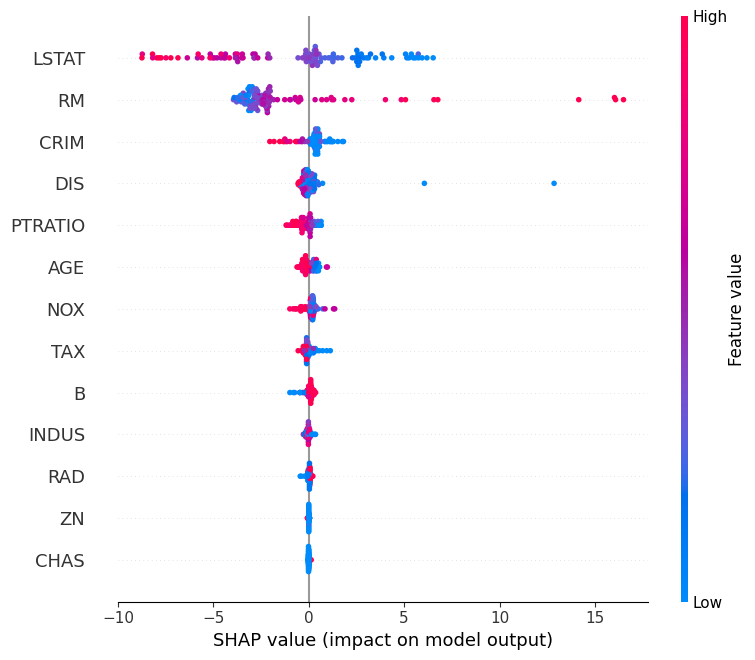

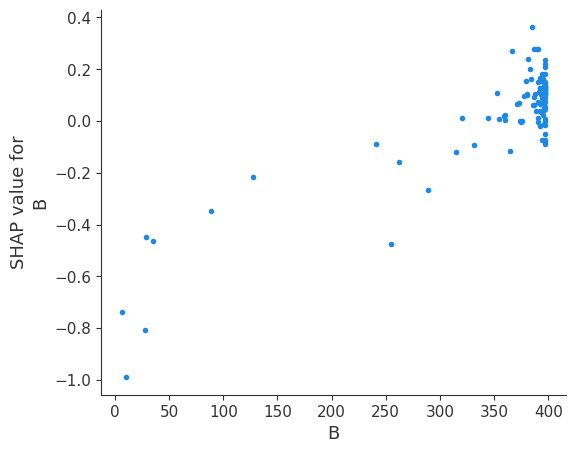

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

data = data_dict['data']
metadata = data_dict['metadata']

# === Separate features and target ===
X = data.drop(columns=['MEDV'])
y = data['MEDV']

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Fit a baseline model ===
model = RandomForestRegressor(random_state=42, n_estimators=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

# === Explainability with SHAP ===
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# === Global importance ===
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# === Focus on potentially biased variable ===
# “B” encodes racial composition (1000*(Bk - 0.63)^2)
# Lower 'B' roughly corresponds to areas with fewer Black residents.
# We can inspect how the model’s predicted prices change as 'B' varies.
shap.dependence_plot(
    "B",
    shap_values,
    X_test,
    interaction_index=None,
    display_features=X_test

)

Mean predicted MEDV (low_B areas): 19.775803921568624
Mean predicted MEDV (high_B areas): 22.957117647058823


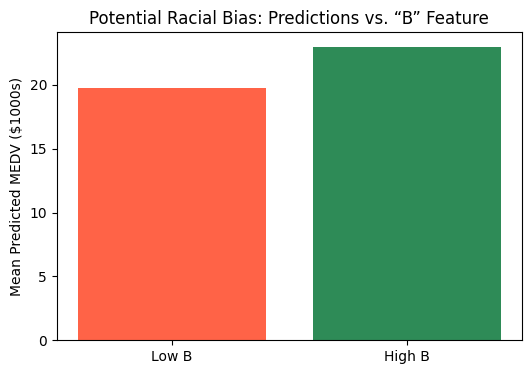

In [11]:
# Group predictions by racial composition
low_B = X_test[X_test['B'] < X_test['B'].median()]
high_B = X_test[X_test['B'] >= X_test['B'].median()]

print("Mean predicted MEDV (low_B areas):", model.predict(low_B).mean())
print("Mean predicted MEDV (high_B areas):", model.predict(high_B).mean())
plt.figure(figsize=(6,4))
plt.bar(['Low B', 'High B'],
        [model.predict(low_B).mean(), model.predict(high_B).mean()],
        color=['tomato', 'seagreen'])
plt.ylabel('Mean Predicted MEDV ($1000s)')
plt.title('Potential Racial Bias: Predictions vs. “B” Feature')
plt.show()
